# Table of Contents
 <p>

In [2]:
import pandas as pd
import numpy as np
import scipy as scipy
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import os

# import own libraries
import pretty_table as pretty

# plotting settings
import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

# more parameters
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [610]:
class model:
    """
    A phenotypic class model. Given the sizes of a set of 8 classes and noise parameters, builds an
    observation matrix and simulates noise from false-positive and false-negative flows. It can also
    test an idealized model after noising with an observed model (must be provided) and return a 
    signal to noise estimate for each class.
    
    properties:
    L
    fp
    fn
    fps
    fns
    N_T
    
    """
    def __init__(self, N_100, N_010, N_001, M000, M100, M010, M001, M110, M101, M011, M111, fp, fn):
        """
        Initialization function for a `model` object.
        
        params:
        N_100, N_010, N_001
        M_ijk
        fp
        fn
        """
        self.N = [N_100, N_010, N_001]
        
        # index matrix, standard for all 3-way comparisons
        L = [[1,0,0],
             [0,1,0],
             [0,0,1],
             [1,1,0],
             [1,0,1],
             [0,1,1],
             [1,1,1],
             [0,0,0]]
        L = np.matrix(L)
        self.L = L
        
        # adjacency matrix
        self.A = [[0, 0, 0, 1, 1, 0, 0],
                  [0, 0, 0, 1, 0, 1, 0],
                  [0, 0, 0, 0, 1, 1, 0],
                  [1, 1, 0, 0, 0, 0, 1],
                  [1, 0, 1, 0, 0, 0, 1],
                  [0, 1, 1, 0, 0, 0, 1]
                 ]
        
        # parameters:
        self.fp = fp
        self.fn = fn
        self.fps = np.zeros(shape=(2,2,2))
        self.fns = np.zeros(shape=(2,2,2))
        self.N_T = M000 + M100 + M010 + M001 + M110 + M101 + M011 + M111

        # initialize the M classes:
        self.make_M(M000, M100, M010, M001, M110, M101, M011, M111)
        
        # noise calculations
        for t in range(0, 3):
            self.false_positive(t)

            for l in self.L:
                if l[0,t] == 1:
                    self.false_negative(t, l)


    def make_M(self, M000, M100, M010, M001, M110, M101, M011, M111):
        """
        Inputs Mijk entries into 3x3 array, and inflates them for false negatives.
        """
        # inflation factor:
        def correction(rank):
            return 1 - self.fn
        # total DE genes counted:
        DE = M100 + M010 + M001 + M110 + M101 + M011 + M111
    
        # make matrix and input coefficients:
        M_mat = np.zeros(shape=(2,2,2))
        
        M_mat[1, 0, 0] = M100
        M_mat[0, 1, 0] = M010
        M_mat[0, 0, 1] = M001
        M_mat[1, 1, 0] = M110
        M_mat[0, 1, 1] = M011
        M_mat[1, 0, 1] = M101
        M_mat[1, 1, 1] = M111
        M_mat[0, 0, 0] = self.N_T - DE
        
        self.M = M_mat


    def find_labels(self, t):
        """Given a genotype t, find all the labels that include that genotype"""
        return self.L[np.where(self.L[:, t] == 1)[0]]


    def find_sub_M(self, t):
        """Find the submatrix of M that only contains entries that include genotype t"""
        return self.M[np.where(self.L[:, t] == 1)[0]]


    def false_positive(self, t):
        """
        Returns the expected false positive distribution for genotype t.
        Note: This function is accurate to O(n**2) ONLY.

        t - the genotype currently being assessed
        M - the matrix containing the size of each class
        L - matrix of genotype labels
        N_t - the total number of false positives expected for t

        output:
        fps -- the false positive hit matrix for the desired subset of Labels
        """
        l = self.find_labels(t)
        for label in l:
            # find labels and classes
            label = label[0]
            M_label = self.M[label[0,0], label[0, 1], label[0, 2]]

            # calculate distribution
            if np.sum(label) > 1:
                fraction = np.sum(M_label)/np.sum(self.M)
            else:
                fraction = (np.sum(M_label) + np.sum(self.M[0,0,0]))/np.sum(self.M)

            # save
            self.fps[label[0, 0], label[0, 1], label[0, 2]] += self.fp*fraction*self.N[t]


    def false_negative(self, t, l):
        """
        Given a single label, l, find its adjacent labels and model false negative flow.
        Note: This function is accurate to O(n**2) ONLY.
        
        params:
        t - genotype currently being assessed
        l - current label, a numpy (1x3) matrix
        M - matrix of class sizes
        L - matrix of labels

        output:
        fns - the false negative hit matrix
        """
        if l[0, t] == 0:
            raise ValueError('label must contain a 1 at the `th` position')

        # adjacent label:
        curr = np.zeros(3)
        curr[t] = 1
        l_adj = l - curr
        l_adj = l_adj.astype(int)

        m_t = self.M[l[0,0], l[0,1], l[0,2]]
        self.fns[l[0,0], l[0,1], l[0,2]] -= self.fn*m_t
        self.fns[l_adj[0,0], l_adj[0,1], l_adj[0,2]] += self.fn*m_t


    def signal_threshold(self, alpha):
        """Sets the signal/noise threshold for testing."""
        self.snr = alpha


    def test_classes(self, M_obs, max_flow):
        """Tests classes against observations and accepts classes based on an alpha value."""
        accepted = np.array([0]*8)
        sn = np.array([0]*8)
                      
        # denoise M_obs:
        self.M_obs = M_obs - self.fns - self.fps
        self.M_obs[self.M_obs < 0] = 0
        
#         # estimate false negative flows
#         self.fn_flow = self.fns/(M_obs + 0.001)
#         self.fp_flow = self.fps/(M_obs + 0.001)
        
#         # reclassify
        prevM = self.M
#         self.reclassify(max_flow)
        
        if (prevM != self.M).all():
            # re-estimate false flows
            self.fps = np.zeros(shape=(2,2,2))
            self.fns = np.zeros(shape=(2,2,2))
            for t in range(0, 3):
                self.false_positive(t)

                for l in self.L:
                    if l[0,t] == 1:
                        self.false_negative(t, l)
        
        # estimate Signal/Noise
#         SN = self.M_obs/(self.fps + 0.0001)
        SN = M_obs/self.M_obs
        
        # accept high signal classes
        for l in self.L:
            signal = SN[l[0,0], l[0,1], l[0,2]]
            if (signal > self.snr) | (signal < 0):
                # find which entry this is in
                # the column is useless
                row, col = np.where(np.all(self.L == l, axis=1))
                accepted[row] = M_obs[l[0,0], l[0,1], l[0,2]]
                sn[row] = signal
        self.accepted = accepted
        self.signal = sn
    
#     def reclassify(self, max_flow):
#         for l in self.L:
#             rankL = l.sum()
#             curr_Mijk = self.M[l[0,0], l[0,1], l[0,2]]
#             curr_fn_flow = self.fn_flow[l[0,0], l[0,1], l[0,2]]
#             curr_fp_flow = self.fp_flow[l[0,0], l[0,1], l[0,2]]

#             # go to next label if there's insufficient flow
#             if curr_fn_flow < max_flow:
#                 continue
#             if rankL == 2:
#                 self.M[1,1,1] = self.M[1,1,1] + curr_Mijk*curr_fn_flow
            
#             if curr_fp_flow < max_flow:
#                 continue

#             self.M[l[0,0], l[0,1], l[0,2]] = curr_Mijk*(1-curr_fn_flow)
#             self.M[l[0,0], l[0,1], l[0,2]] -= curr_Mijk*curr_fp_flow


In [611]:
def find_k_min(classes):
    """An algorithm to find the minimal set for initialization of a `model`"""
    a = np.zeros(8)
    if classes[7] > 0:
        a[7] = classes[7]
        return a
    elif (classes[3:] > 0).any():
        a[3:] = classes[3:]
        return a
    else:
        return classes

In [612]:
def iterate(M_obs, N_A, N_B, N_C, k_min, fn=0.1, fp=0.1, alpha=5, max_iter=10, max_flow=.3):
    """
    Progressively refines an object until the object converges or iterations exceed a maximum.
    """
    min_model = model(N_A, N_B, N_C, *k_min, fn=fn, fp=fp)
    min_model.signal_threshold(alpha)
    min_model.test_classes(M_obs.M, max_flow)

    x = True
    prev_model = min_model
    i = 0
    while x:
        curr_model = model(N_A, N_B, N_C, prev_model.accepted[-1],
                           *prev_model.accepted[0:-1], fn=fp, fp=fp)
        curr_model.signal_threshold(alpha)
        curr_model.test_classes(M_obs.M, max_flow)

        if (curr_model.accepted == prev_model.accepted).all():
            x = False
        else:
            prev_model = curr_model
        i += 1
        if i > max_iter:
            x = False
            print('Warning, maximum number of iterations exceeded, terminating prematurely.')

    return curr_model

In [613]:
def random_set():
    """
    Generates a random set of M_ijk (without noise), and N_ijk values.
    """
    real = np.random.randint(0, 2, 7)
    # prevent all 0's
    while np.sum(real) < 3:
        real = np.random.randint(0, 2, 7)

    classes = np.random.randint(10, 2000, 7)
    classes[np.where(real == 0)] = 0
    
    N_A = classes[0] + classes[3] + classes[4]  + classes[6]
    N_B = classes[1] + classes[3] + classes[5]  + classes[6]
    N_C = classes[2] + classes[4] + classes[5]  + classes[6]
    N_T = 21000
    
    sizes = np.append(np.array(N_T), classes)
    true_classes = np.append(classes, [N_T])
    N = [N_A, N_B, N_C]
    
    return N, true_classes, sizes

def noise_model(N, sizes, fn, fp):
    """Given a genome size, N, class sizes and false rates, returns a `model` of a noised M_ijk matrix. 
    """
    M = model(*N, *sizes, fn=fn, fp=fp)
    if (fp == 0) | (fn == 0):
        M_mat = M.M
    else:
        M_mat = M.M + np.random.normal(M.fps, np.abs(M.fps) + 5) + np.random.normal(M.fns, np.abs(M.fns) + 5)
        M_mat[np.where(M_mat < 0)] = 0
    m_vector = (M_mat[0,0,0], M_mat[1,0,0], M_mat[0,1,0],
                M_mat[0,0,1], M_mat[1,1,0], M_mat[1,0,1],
                M_mat[0,1,1], M_mat[1,1,1])
    M_obs = model(*N, *m_vector, fn=0, fp=0)
    return M_obs

def loop(M_obs, N, true_classes, sizes, alpha=5, fp=0.1, fn=0.1, max_flow=.3):
    k_min = find_k_min(sizes)
    final = iterate(M_obs, *N, k_min, alpha=alpha, fp=fp, fn=fn, max_flow=max_flow)

    correct = np.zeros(8)
    calls = np.chararray(8, itemsize=7)
    for i, c in enumerate(true_classes):
        if c == 0:
            if final.accepted[i] == 0:
                correct[i] = True
                calls[i] = 'true_0'
            else:
                correct[i] = False
                calls[i] = 'false_0'
        else:
            if final.accepted[i] > 0:
                correct[i] = True
                calls[i] = 'true_1'
            else:
                correct[i] = False
                calls[i] = 'false_1'

    return correct, final.signal, calls

In [614]:
def run(alpha, fp, fn, iters=1000, max_flow=.30):
    """Implements the false-hit algorithm `iters` times with random initializations"""
    iters = iters
    random_classes = np.empty(shape=(iters, 8))
    classifications = np.empty(shape=(iters, 8))
    signals = np.empty(shape=(iters, 8))
    calls = np.chararray(shape=(iters, 8), itemsize=7)
    for i in range(iters):
        N, true_classes, sizes = random_set()
        M_obs = noise_model(N, sizes, fp=fp, fn=fn)
        correct, signal, call = loop(M_obs, N, true_classes, k_min,
                                      alpha=alpha, fp=fp, fn=fn,
                                     max_flow=max_flow)
        random_classes[i, :] = true_classes
        classifications[i] = correct
        signals[i] = signal
        calls[i] = call
    return random_classes, classifications, signals, calls

In [615]:
def noise(sigma=0.05, iters=1000):
    return np.random.normal(0, sigma, iters)

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def rc(classes, classifications, entry, subset=None, **kwargs):
    if subset:
        index = np.random.randint(0, len(classes[:, entry]), subset)
        r = classes[:, entry][index]
        c = classifications[:, entry][index]
        
        sorter = np.argsort(r)
        r = r[sorter]
        c = c[sorter] + noise(iters=subset)
        return r, c
    else:
        sorter = np.argsort(classes[:,entry])
        r = classes[:,entry][sorter]
        c = classifications[:,entry][sorter] + noise(**kwargs)
        return r, c

def interpol(classes, classifications, entry, s=10):
    r, c = rc(entry)
    f = scipy.interpolate.UnivariateSpline(running_mean(r, 10), running_mean(c, 10), s=s)
    xs = np.linspace(50, 1750, 50)
    return xs, f(xs)

def run_mean(classes, classifications, entry, interval, **kwargs):
    r, c = rc(classes, classifications, entry, **kwargs)
    return running_mean(r, interval), running_mean(c, interval)

In [616]:
def make_pretty_plots(classes, classifications, iters=1000):
    fig, ax = plt.subplots(ncols=3, figsize=(15, 4), sharey=True)
    ax[0].plot(*rc(classes, classifications, 1, subset=500, iters=iters), 'o', alpha=0.5, ms=3)
    ax[0].plot(*run_mean(classes, classifications, 1, 50, iters=iters), 'r')
    ax[0].set_title('Singly labelled class')
    ax[0].set_ylabel('Correct classification')

    ax[1].plot(*rc(classes, classifications, 5, subset=500, iters=iters), 'o', alpha=0.5, ms=3)
    ax[1].plot(*run_mean(classes, classifications, 5, 50, iters=iters), 'r')
    ax[1].set_title('Doubly labelled class')
    ax[1].set_xlabel('Number of DE genes in class')

    ax[2].plot(*rc(classes, classifications, 6, subset=500, iters=iters), 'o', alpha=0.5, ms=3)
    ax[2].plot(*run_mean(classes, classifications, 6, 50, iters=iters), 'r')
    ax[2].set_title('Triply labelled class')
    return fig, ax

def true_negative_rate(random_classes, classifications, calls):
    x = np.where(random_classes[:, 1] == 0)
    l = len(classifications[:,1][x])
    rate = classifications[:, 1][x].sum()/l
    rate1 = classifications[:, 5][x].sum()/l
    rate2 = classifications[:, 6][x].sum()/l
#     m = 'Fraction called correctly: {0:.2g}, {1:.2g}, {2:.2g}'.format(rate, rate1, rate2)
    
    n_false1 = len(calls[np.where(calls[:, 1] == b'false_1'), 1][0])
    n_false0 = len(calls[np.where(calls[:, 1] == b'false_0'), 1][0])
    m2 = '# real classes type 1 called wrong {0}'.format(n_false1)
    m3 = '# empty classes type 1 called wrong {0}'.format(n_false0)
    
    n_false12 = len(calls[np.where(calls[:, 5] == b'false_1'), 5][0])
    n_false02 = len(calls[np.where(calls[:, 5] == b'false_0'), 5][0])
    m4 = '# real classes type 5 called wrong {0}'.format(n_false12)
    m5 = '# empty classes type 5 called wrong {0}'.format(n_false02)

    n_false13 = len(calls[np.where(calls[:, 6] == b'false_1'), 6][0])
    n_false03 = len(calls[np.where(calls[:, 6] == b'false_0'), 6][0])
    m6 = '# real classes type 6 called wrong {0}'.format(n_false13)
    m7 = '# empty classes type 6 called wrong {0}'.format(n_false03)

#     print(m)
    print(m2)
    print(m3)
    print(m4)
    print(m5)
    print(m6)
    print(m7)


def true_positive_rate(random_classes, classifications, calls):
    x = np.where(random_classes[:, 1] > 0)
    l =len(classifications)
    rate = classifications[:, 1][x].sum()/l
    rate1 = classifications[:, 5][x].sum()/l
    rate2 = classifications[:, 6][x].sum()/l
#     m = 'Fraction called correctly: {0:.2g}, {1:.2g}, {2:.2g}'.format(rate, rate1, rate2)
#     print(m)
    
    n_true1 = len(calls[np.where(calls[:, 1] == b'true_1'), 1][0])
    n_true0 = len(calls[np.where(calls[:, 1] == b'true_0'), 1][0])
    m2 = '# real classes 1 called correctly {0}'.format(n_true1)
    m3 = '# empty classes 1 called correctly {0}'.format(n_true0)

    n_true12 = len(calls[np.where(calls[:, 5] == b'true_1'), 5][0])
    n_true02 = len(calls[np.where(calls[:, 5] == b'true_0'), 5][0])
    m4 = '# real classes 5 called correctly {0}'.format(n_true12)
    m5= '# empty classes 5 called correctly {0}'.format(n_true02)

    n_true12 = len(calls[np.where(calls[:, 6] == b'true_1'), 6][0])
    n_true02 = len(calls[np.where(calls[:, 6] == b'true_0'), 6][0])
    m6 = '# real classes 6 called correctly {0}'.format(n_true12)
    m7 = '# empty classes 6 called correctly {0}'.format(n_true02)
    
    print(m2)
    print(m3)
    print(m4)
    print(m5)
    print(m6)
    print(m7)


In [620]:
def study(alpha, fp, fn, iters=1000, max_flow=1):
    random_classes, classifications, signals, calls = run(alpha, fp, fn, iters, max_flow=max_flow)
    fig, ax = make_pretty_plots(random_classes, classifications, iters)
    fig.suptitle('Params: alpha={0}, q={1}, f={2}'.format(alpha, fp, fn), y=1.04,
                 fontsize=18)
    
    true_positive_rate(random_classes, classifications, calls)
    true_negative_rate(random_classes, classifications, calls)
    return fig, ax

# real classes 1 called correctly 516
# empty classes 1 called correctly 423
# real classes 5 called correctly 571
# empty classes 5 called correctly 413
# real classes 6 called correctly 581
# empty classes 6 called correctly 419
# real classes type 1 called wrong 61
# empty classes type 1 called wrong 0
# real classes type 5 called wrong 16
# empty classes type 5 called wrong 0
# real classes type 6 called wrong 0
# empty classes type 6 called wrong 0


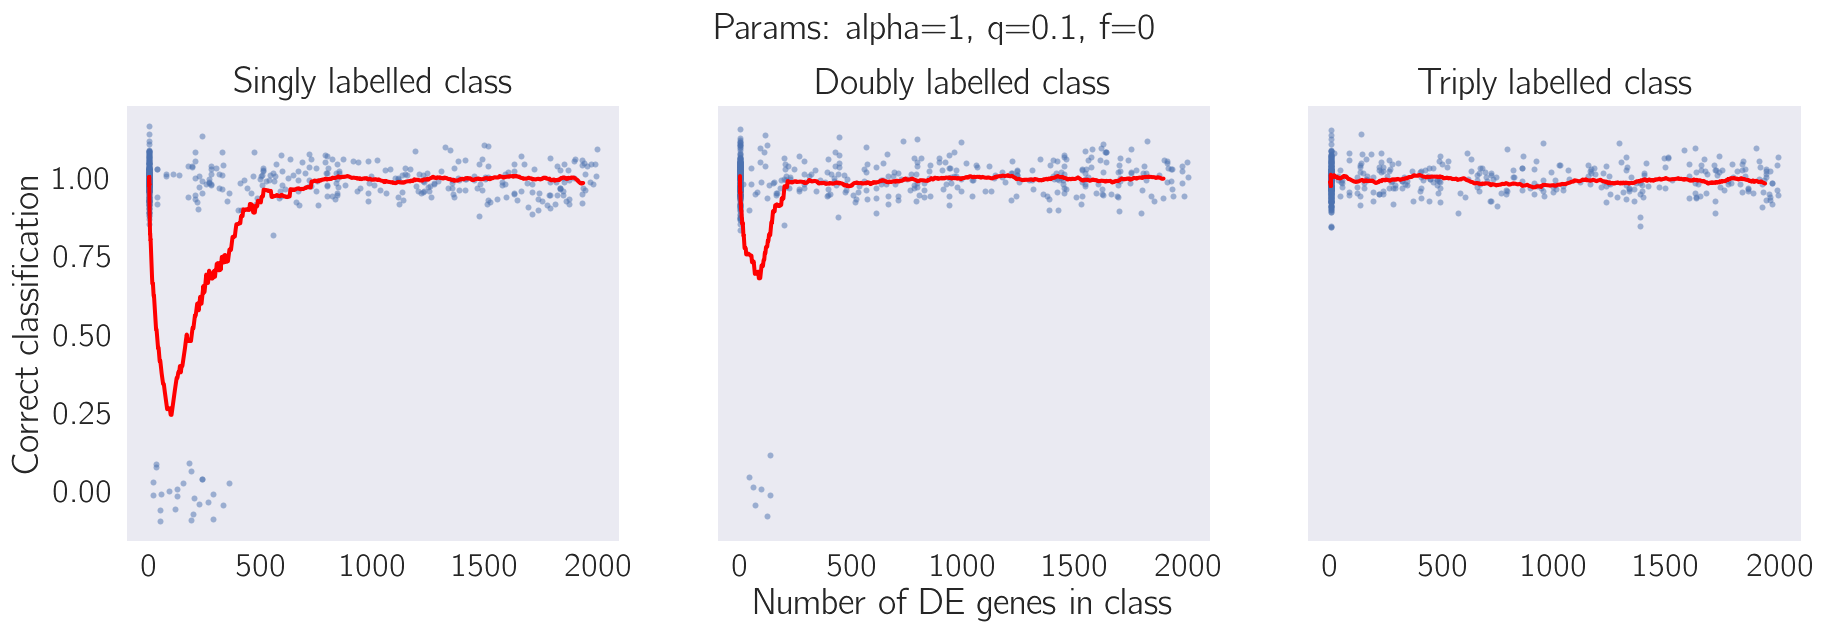

In [621]:
fig, ax = study(1, 0.1, 0)

# real classes 1 called correctly 481
# empty classes 1 called correctly 368
# real classes 5 called correctly 551
# empty classes 5 called correctly 210
# real classes 6 called correctly 582
# empty classes 6 called correctly 215
# real classes type 1 called wrong 94
# empty classes type 1 called wrong 57
# real classes type 5 called wrong 3
# empty classes type 5 called wrong 236
# real classes type 6 called wrong 6
# empty classes type 6 called wrong 197


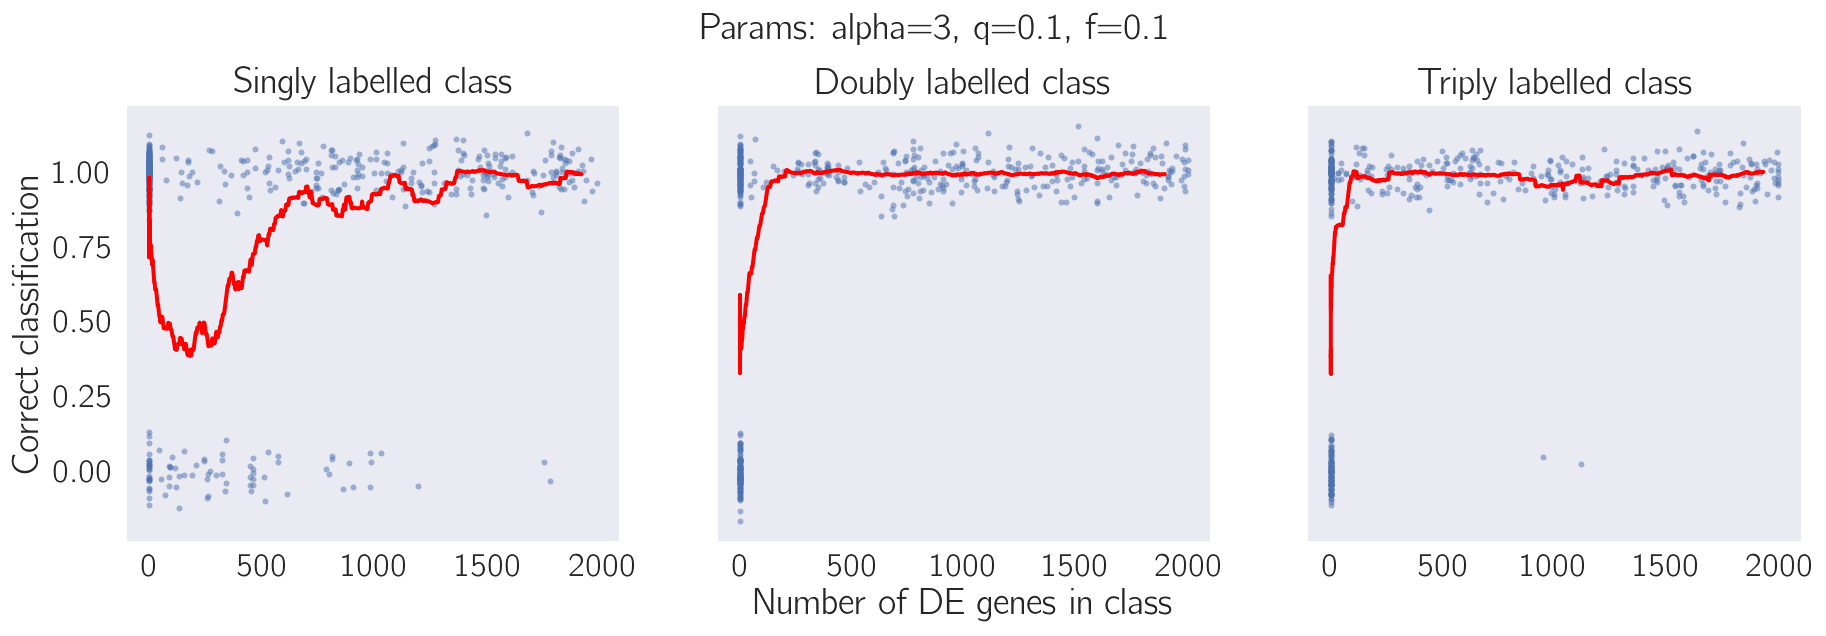

In [628]:
fig, ax = study(3, 0.1, 0.1)

# real classes 1 called correctly 403
# empty classes 1 called correctly 413
# real classes 5 called correctly 581
# empty classes 5 called correctly 198
# real classes 6 called correctly 557
# empty classes 6 called correctly 251
# real classes type 1 called wrong 164
# empty classes type 1 called wrong 20
# real classes type 5 called wrong 2
# empty classes type 5 called wrong 219
# real classes type 6 called wrong 3
# empty classes type 6 called wrong 189


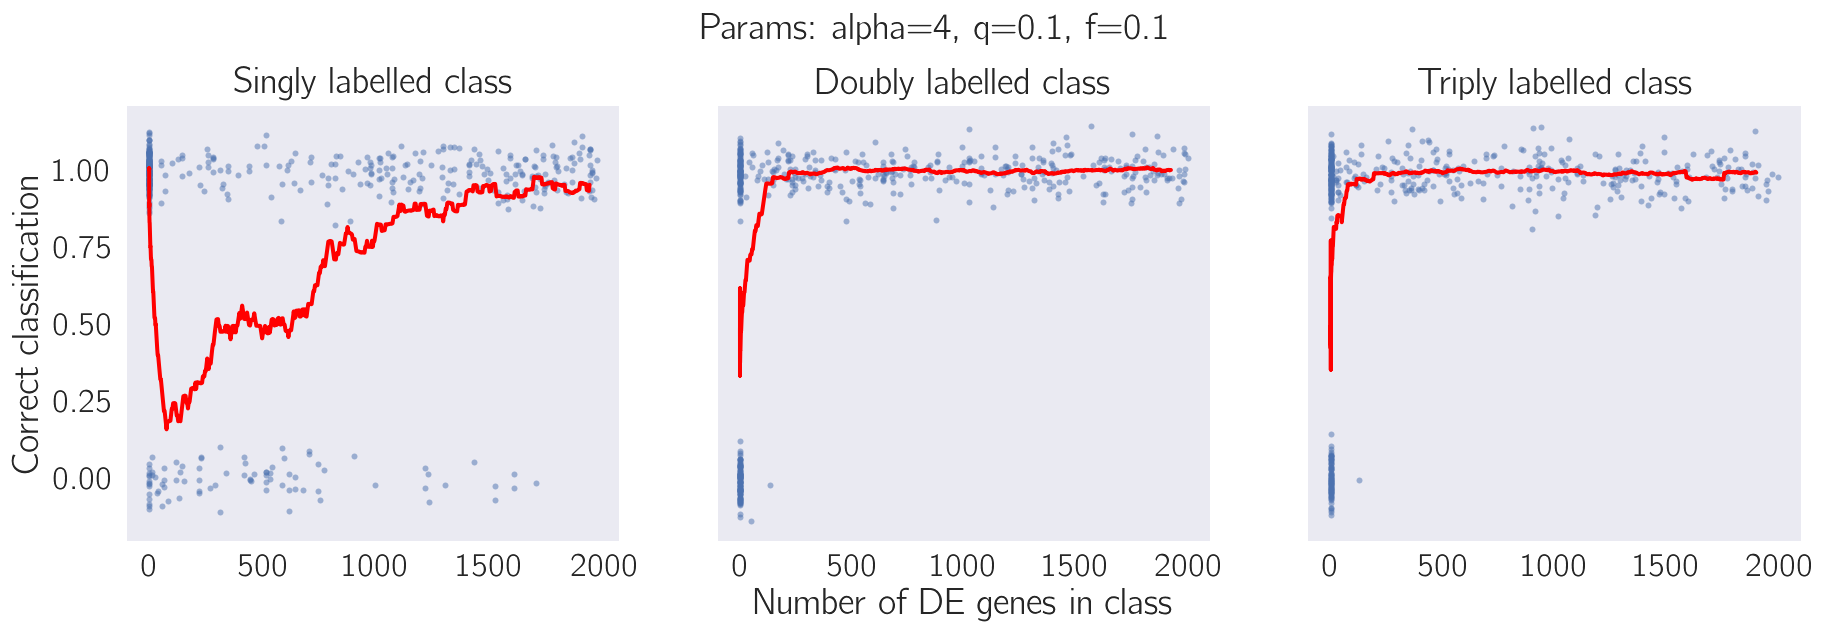

In [629]:
fig, ax = study(4, 0.1, 0.1)

# real classes 1 called correctly 569
# empty classes 1 called correctly 174
# real classes 5 called correctly 560
# empty classes 5 called correctly 143
# real classes 6 called correctly 554
# empty classes 6 called correctly 264
# real classes type 1 called wrong 6
# empty classes type 1 called wrong 251
# real classes type 5 called wrong 1
# empty classes type 5 called wrong 296
# real classes type 6 called wrong 10
# empty classes type 6 called wrong 172


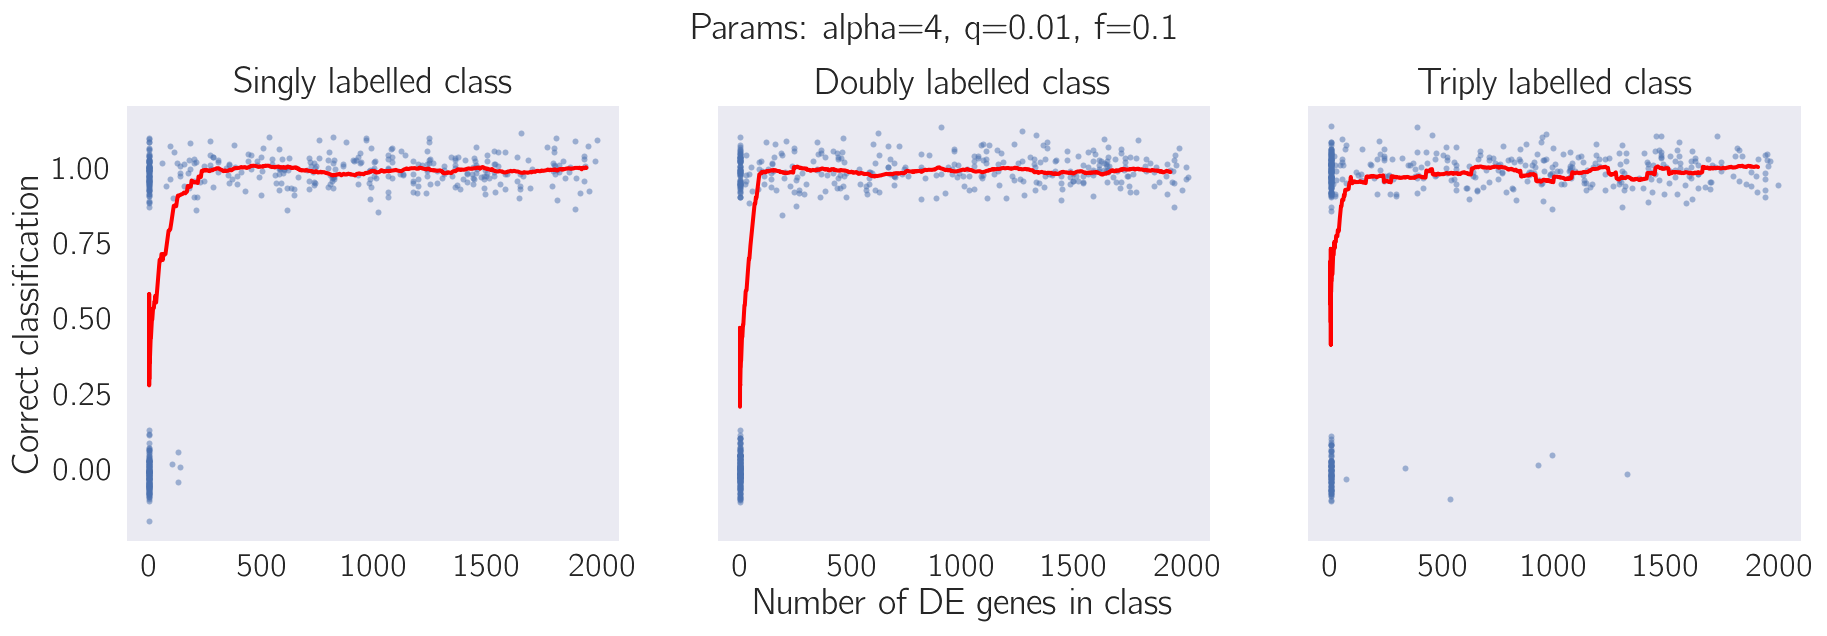

In [630]:
fig, ax = study(4, 0.01, 0.1)

# real classes 1 called correctly 573
# empty classes 1 called correctly 233
# real classes 5 called correctly 597
# empty classes 5 called correctly 124
# real classes 6 called correctly 577
# empty classes 6 called correctly 226
# real classes type 1 called wrong 10
# empty classes type 1 called wrong 184
# real classes type 5 called wrong 4
# empty classes type 5 called wrong 275
# real classes type 6 called wrong 7
# empty classes type 6 called wrong 190


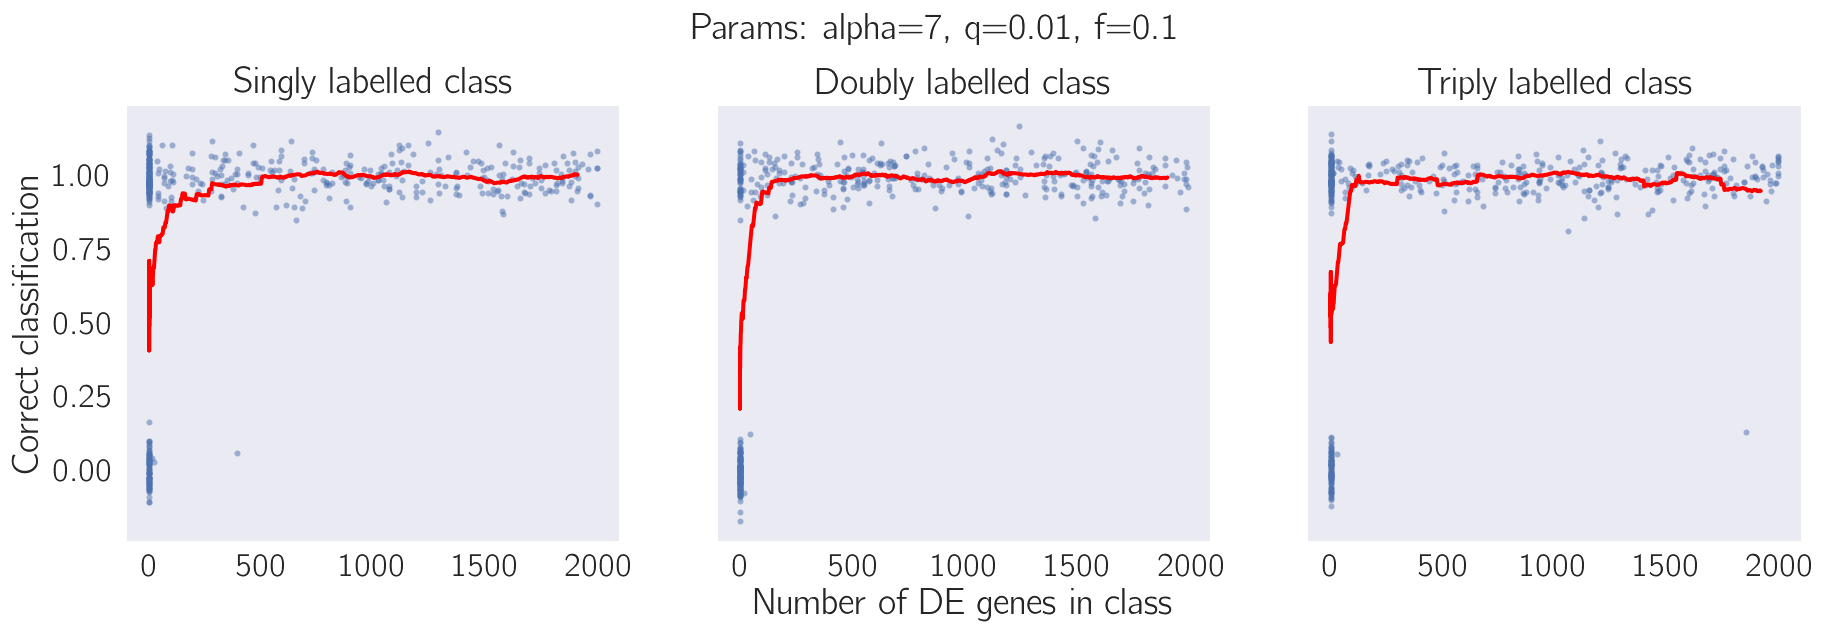

In [631]:
fig, ax = study(7, 0.01, 0.1)

# real classes 1 called correctly 347
# empty classes 1 called correctly 421
# real classes 5 called correctly 577
# empty classes 5 called correctly 149
# real classes 6 called correctly 529
# empty classes 6 called correctly 233
# real classes type 1 called wrong 197
# empty classes type 1 called wrong 35
# real classes type 5 called wrong 5
# empty classes type 5 called wrong 269
# real classes type 6 called wrong 51
# empty classes type 6 called wrong 187


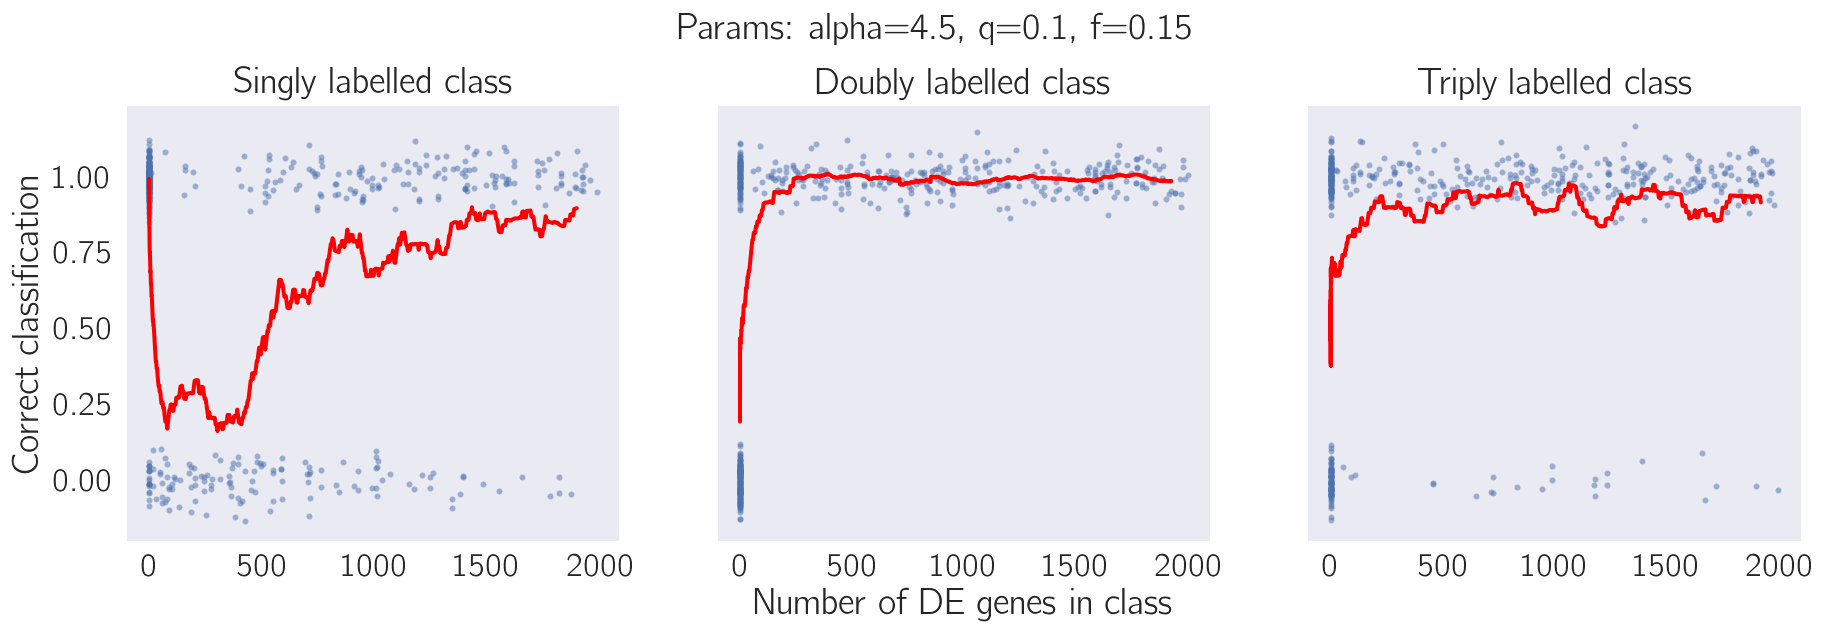

In [632]:
fig, ax = study(4.5, 0.1, 0.15)

# real classes 1 called correctly 568
# empty classes 1 called correctly 147
# real classes 5 called correctly 551
# empty classes 5 called correctly 141
# real classes 6 called correctly 414
# empty classes 6 called correctly 247
# real classes type 1 called wrong 13
# empty classes type 1 called wrong 272
# real classes type 5 called wrong 31
# empty classes type 5 called wrong 277
# real classes type 6 called wrong 147
# empty classes type 6 called wrong 192


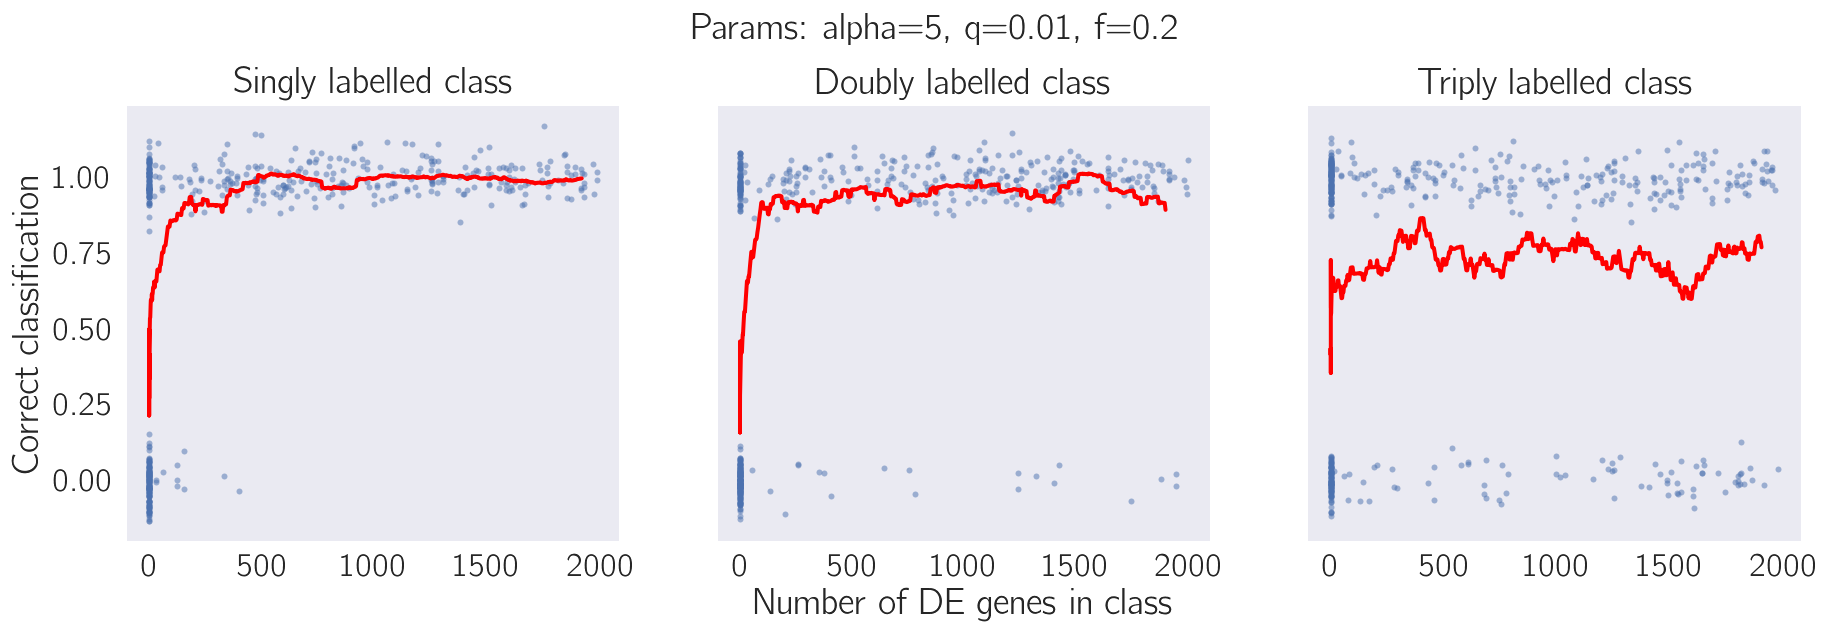

In [633]:
fig, ax = study(5, 0.01, 0.2)

In [ ]:
fig, ax = study(4, 0.05, 0.5)

In [ ]:
N_t = 21954
M_obs = model(2800, 481, 2214, N_t, 1800, 78, 1226, 106, 720, 57, 242, fn=0, fp=0)
k_min = (N_t-242, 0, 0, 0, 0, 0, 0, 242)
final = iterate(M_obs, 2800, 481, 2214, k_min, alpha=4.5, fp=0.1, fn=.99)
final.accepted
chi_final = ((M_obs.M - (final.M + final.fps + final.fns))**2).sum()

In [637]:
M_obs.M/(final.fps + final.fns)

array([[[ 65.29610046,   8.82099539],
        [  1.95566572,   2.11983471]],

       [[ 13.45691077,  -6.11990286],
        [  3.94214876,  -3.22791058]]])

In [638]:
M_final = model(2800, 481-78, 2214, N_t, 1800, 0, 1226, 0, 720, 0, 415, fp=0.1, fn=0.1)
M_final.signal_threshold(4)
M_final.test_classes(M_obs.M)
M_final.accepted
chi_refined = (M_obs.M - (M_final.M + M_final.fps + M_final.fns))**2

In [639]:
chi_refined < chi_final

array([[[ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True]]], dtype=bool)

In [641]:
N_t = 21954
N = [1562, 305, 848]
Mijk = np.array([1562, 60, 871, 61, 541, 37, 176])
M_obs = model(*N, N_t, *Mijk, fn=0, fp=0)
k_min = (N_t-176, 0, 0, 0, 0, 0, 0, 176)
final = iterate(M_obs, *N, k_min, alpha=4, fp=0.01, fn=0.3)
chi_final = ((M_obs.M - (final.M + final.fps + final.fns))**2).sum()
final.accepted

array([ 1562,    60,   871,    61,   541,    37,   176, 21954])

In [642]:
M_obs.M/(final.fps + final.fns)

array([[[ 871.81949458,  185.55272129],
        [  19.7515843 ,   35.32688246]],

       [[ 323.22555728,  -62.68694009],
        [ 103.21624183,  -34.22613622]]])

In [644]:
N = [1562, 245, 848]
Mijk = np.array([1562, 0, 871, 0, 541, 0, 274])
M_final = model(*N, N_t, *Mijk, fp=0.01, fn=0.3)
M_final.signal_threshold(4)
M_final.test_classes(M_obs.M)
chi_refined = (M_obs.M - (M_final.M + M_final.fps + M_final.fns))**2
M_final.accepted


array([ 1562,    60,   871,     0,   541,     0,   176, 21954])

In [645]:
chi_refined < chi_final

array([[[False, False],
        [False, False]],

       [[False, False],
        [False, False]]], dtype=bool)

In [650]:
N_t = 21954
N = [3304, 565, 2776]
Mijk = np.array([2030, 93, 1548, 115, 915, 61, 299])
M_obs = model(*N, N_t, *Mijk, fn=0, fp=0)
k_min = (N_t-299, 0, 0, 0, 0, 0, 0, 299)
final = iterate(M_obs, *N, k_min, alpha=4, fp=0.15, fn=0.15)
chi_final = ((M_obs.M - (final.M + final.fps + final.fns))**2).sum()
final.accepted

array([ 2030,     0,     0,     0,   915,     0,   299, 21954])

In [651]:
N = [3304, 565-93, 2776]
Mijk = np.array([2030, 0, 1548, 0, 915, 0, 415])
M_final = model(*N, N_t, *Mijk, fp=0.01, fn=0.3)
M_final.signal_threshold(4)
M_final.test_classes(M_obs.M)
chi_refined = (M_obs.M - (M_final.M + M_final.fps + M_final.fns))**2
M_final.accepted


array([ 2030,    93,  1548,     0,   915,     0,   299, 21954])

In [652]:
chi_refined < chi_final

array([[[ True,  True],
        [ True,  True]],

       [[ True,  True],
        [ True,  True]]], dtype=bool)

In [35]:
N_t = 21954
M_obs = model(3000, 3000, 0, N_t, 3000, 3000, 0, 0, 0, 0, 0, fn=0.1, fp=0.1)
# k_min = (N_t-242, 0, 0, 0, 0, 0, 0, 242)
# final = iterate(M_obs, 2800, 481, 2214, k_min, alpha=4.5, fp=0.1, fn=.99)
# final.accepted
# chi_final = ((M_obs.M - (final.M + final.fps + final.fns))**2).sum()

In [36]:
M_obs.M

array([[[ 21287.33333333,      0.        ],
        [  3333.33333333,      0.        ]],

       [[  3333.33333333,      0.        ],
        [     0.        ,      0.        ]]])

In [37]:
M_obs.fns

array([[[ 666.66666667,    0.        ],
        [-333.33333333,    0.        ]],

       [[-333.33333333,    0.        ],
        [   0.        ,    0.        ]]])

In [38]:
M_obs.fps

array([[[   0.        ,    0.        ],
        [ 264.22694427,    0.        ]],

       [[ 264.22694427,    0.        ],
        [   0.        ,    0.        ]]])

In [39]:
M_obs.fps[0,0,1]

0.0